In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import os

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

# Preparing the data

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 4
EPOCHS = 60
NUM_CLASSES = 4


In [6]:
normal_dir = os.listdir("/kaggle/input/Monkeypox Skin Image Dataset/Normal")
chickenpox_dir = os.listdir("/kaggle/input/Monkeypox Skin Image Dataset/Chickenpox")
monkeypox_dir = os.listdir("/kaggle/input/Monkeypox Skin Image Dataset/Monkeypox")
measles_dir = os.listdir("/kaggle/input/Monkeypox Skin Image Dataset/Measles")

In [7]:
len(normal_dir),len(chickenpox_dir),len(monkeypox_dir),len(measles_dir)

(293, 107, 279, 91)

In [13]:
def our_data(normal_dir, chickenpox_dir, monkeypox_dir, measles_dir):
    dataset = []
    labels = []
    normal_base_dir="/kaggle/input/Monkeypox Skin Image Dataset/Normal"
    chickenpox_base_dir="/kaggle/input/Monkeypox Skin Image Dataset/Chickenpox"
    monkeypox_base_dir="/kaggle/input/Monkeypox Skin Image Dataset/Monkeypox"
    measles_base_dir="/kaggle/input/Monkeypox Skin Image Dataset/Measles"

    for img in (normal_dir):
        dataset.append(os.path.join(normal_base_dir, img))
        labels.append(0)  # Normal

    for img in (chickenpox_dir):
        dataset.append(os.path.join(chickenpox_base_dir, img))
        labels.append(1)  # Chickenpox

    for img in (monkeypox_dir):
        dataset.append(os.path.join(monkeypox_base_dir, img))
        labels.append(2)  # Monkeypox

    for img in (measles_dir):
        dataset.append(os.path.join(measles_base_dir, img))
        labels.append(3)  # Measles

    # Combine and shuffle
    data = list(zip(dataset, labels))
    
    random.shuffle(data)
    return data

In [14]:
data=our_data(normal_dir, chickenpox_dir, monkeypox_dir, measles_dir)
len(data)

770

In [15]:
data[:5]

[('/kaggle/input/Monkeypox Skin Image Dataset/Normal/normal128.png', 0),
 ('/kaggle/input/Monkeypox Skin Image Dataset/Monkeypox/monkeypox79.png', 2),
 ('/kaggle/input/Monkeypox Skin Image Dataset/Measles/measles64.png', 3),
 ('/kaggle/input/Monkeypox Skin Image Dataset/Monkeypox/monkeypox211.png', 2),
 ('/kaggle/input/Monkeypox Skin Image Dataset/Normal/normal262.png', 0)]

In [16]:
dataset, labels = zip(*data)

In [17]:
images = np.array([img_to_array(load_img(file, target_size=(IMG_HEIGHT, IMG_WIDTH))) / 255.0 for file in dataset])
images.shape

(770, 224, 224, 3)

In [18]:
labels=np.array(labels) 
labels[0]

0

In [20]:
labels.shape

(770,)

In [21]:
labels = to_categorical(labels, num_classes=NUM_CLASSES)
labels[0]

array([1., 0., 0., 0.])

## Split the data and use data-generator

In [22]:

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42,stratify=labels)


In [23]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)  
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (616, 224, 224, 3)
Shape of y_train: (616, 4)
Shape of X_val: (154, 224, 224, 3)
Shape of y_val: (154, 4)


In [24]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.1,
                                   zoom_range=0.3,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator()  

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

# Use VGG16 as Feature Extracture

In [25]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_HEIGHT, 3))

for layer in vgg16_base.layers:
    layer.trainable = False

feature_extractor = Model(inputs=vgg16_base.input, outputs=Flatten()(vgg16_base.output))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Extract features for train and validation sets
X_train_features = feature_extractor.predict(X_train, batch_size=BATCH_SIZE, verbose=1)
X_val_features = feature_extractor.predict(X_val, batch_size=BATCH_SIZE, verbose=1)

154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


# Use RandomForest as classifier 

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train_features, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [30]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred) 
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Validation Accuracy: 0.64
Classification Report:
              precision    recall  f1-score   support

      Normal       0.55      1.00      0.71        59
  Chickenpox       1.00      0.10      0.17        21
   Monkeypox       0.86      0.68      0.76        56
     Measles       0.00      0.00      0.00        18

    accuracy                           0.64       154
   macro avg       0.60      0.44      0.41       154
weighted avg       0.66      0.64      0.57       154



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


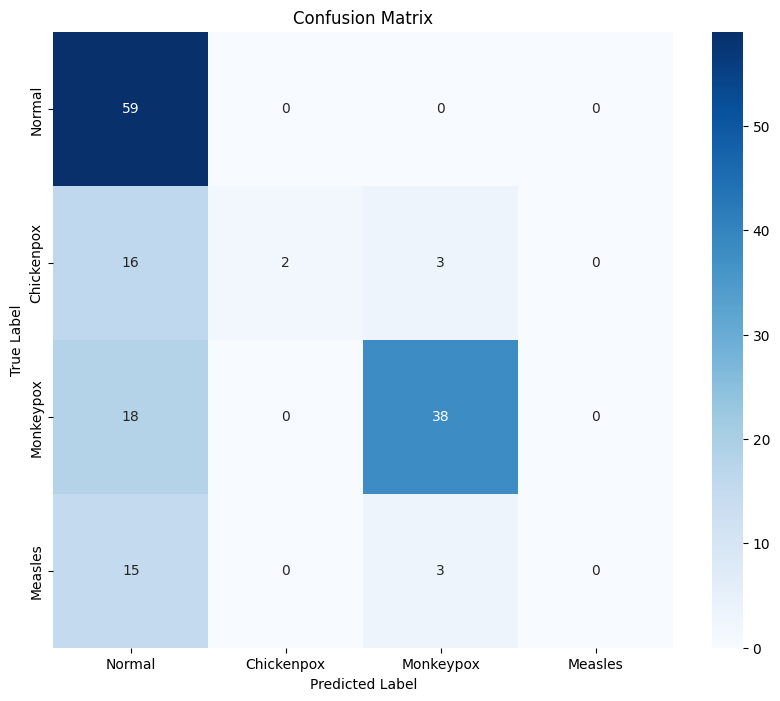

In [31]:
CLASS_NAMES = ["Normal","Chickenpox",  "Monkeypox","Measles" ]

y_val_pred = rf_classifier.predict(X_val_features)

if y_val_pred.ndim > 1:  
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
else:
    y_val_pred_labels = y_val_pred

# Convert true labels to categorical indices
y_val_labels = np.argmax(y_val, axis=1)



accuracy = accuracy_score(y_val_labels, y_val_pred_labels)
print(f"Validation Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_val_labels, y_val_pred_labels, target_names=CLASS_NAMES))

plot_confusion_matrix(y_val_labels, y_val_pred_labels, CLASS_NAMES)

# Use SVC as classifier

In [32]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', probability=True)

y_train_labels = np.argmax(y_train, axis=1)  # Convert one-hot to categorical indices
svm_classifier.fit(X_train_features, y_train_labels)


SVC(kernel='linear', probability=True)

In [34]:
y_val_pred = svm_classifier.predict(X_val_features)

y_val_labels = np.argmax(y_val, axis=1)

Validation Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.86      0.88        59
  Chickenpox       0.71      0.57      0.63        21
   Monkeypox       0.70      0.84      0.76        56
     Measles       0.69      0.50      0.58        18

    accuracy                           0.77       154
   macro avg       0.75      0.69      0.71       154
weighted avg       0.78      0.77      0.77       154



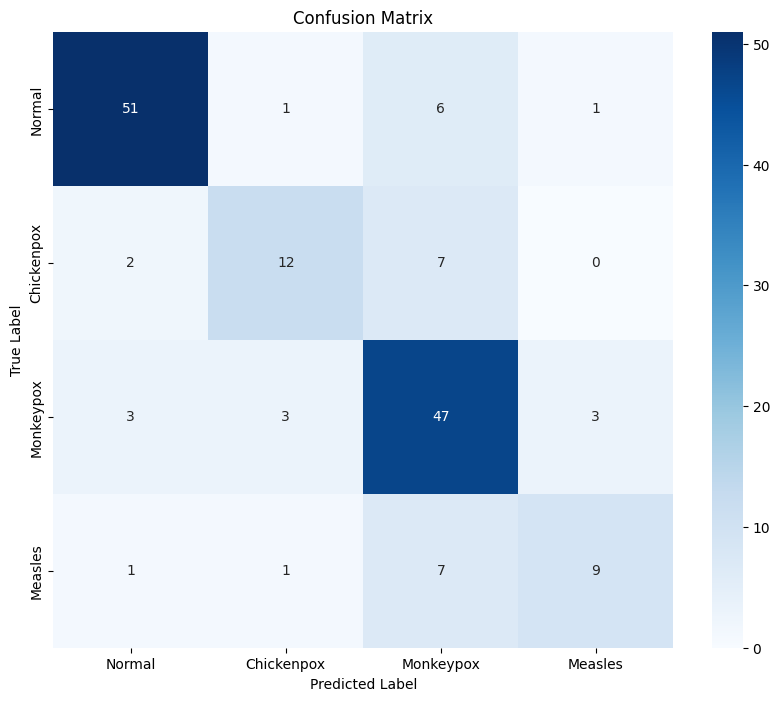

In [35]:
CLASS_NAMES = ["Normal","Chickenpox",  "Monkeypox","Measles" ]

accuracy = accuracy_score(y_val_labels, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_val_labels, y_val_pred, target_names=CLASS_NAMES))


plot_confusion_matrix(y_val_labels, y_val_pred, CLASS_NAMES)

# CNN Model

In [36]:
def create_model():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model


In [37]:
model = create_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,397,572 (74.00 MB)

 Trainable params: 19,396,612 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [39]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


154/154 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.4288 - loss: 19.2867 - val_accuracy: 0.3571 - val_loss: 7.8987
Epoch 2/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.3992 - loss: 6.5110 - val_accuracy: 0.2792 - val_loss: 3.9353
Epoch 3/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4650 - loss: 2.5438 - val_accuracy: 0.4805 - val_loss: 1.2754
Epoch 4/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4974 - loss: 1.4383 - val_accuracy: 0.5649 - val_loss: 1.2358
Epoch 5/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5250 - loss: 1.2618 - val_accuracy: 0.5390 - val_loss: 1.1771
Epoch 6/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4899 - loss: 1.2883 - val_accuracy: 0.5974 - val_loss: 1.3739
Epoch 7/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5368 - loss: 1.1749 - val_accuracy: 0.5779 - val_loss: 1.0717
Epoch 8/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5748 - loss: 1.2197 - val_accuracy: 0.6

In [41]:
def plot_training_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

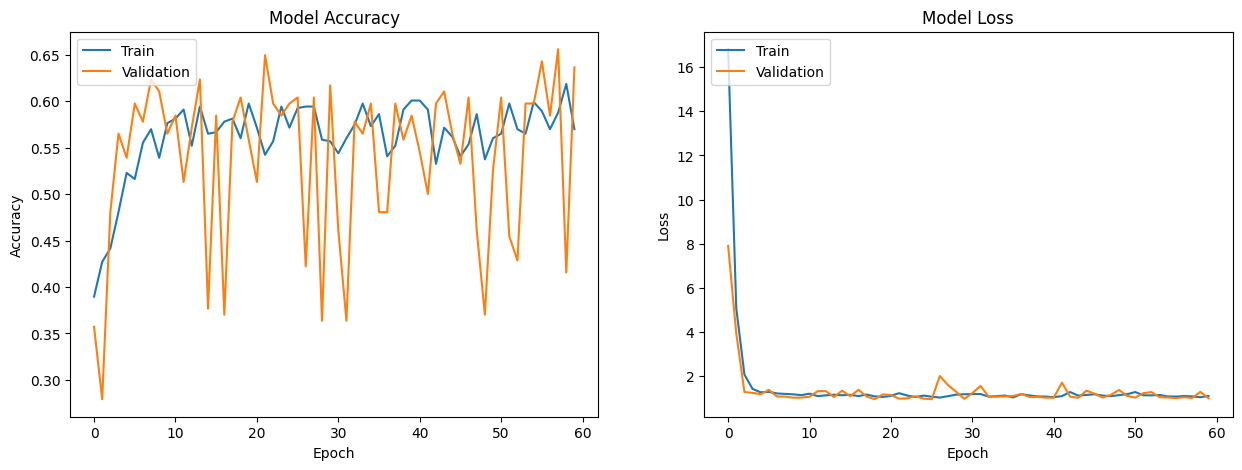

In [42]:
plot_training_results(history)

In [44]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


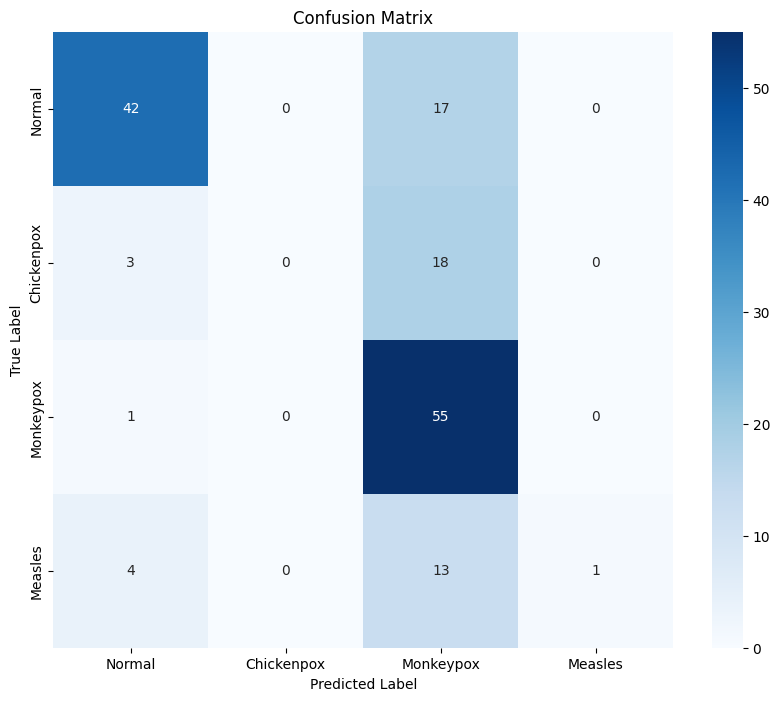


Classification Report:
              precision    recall  f1-score   support

      Normal       0.84      0.71      0.77        59
  Chickenpox       0.00      0.00      0.00        21
   Monkeypox       0.53      0.98      0.69        56
     Measles       1.00      0.06      0.11        18

    accuracy                           0.64       154
   macro avg       0.59      0.44      0.39       154
weighted avg       0.63      0.64      0.56       154



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
y_pred = model.predict(X_val)

class_names = ['Normal', 'Chickenpox', 'Monkeypox', 'Measles']
plot_confusion_matrix(y_val, y_pred, class_names)

print("\nClassification Report:")
print(classification_report(np.argmax(y_val, axis=1), 
                          np.argmax(y_pred, axis=1),
                          target_names=class_names))

# VGG16

In [46]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_HEIGHT, 3))

for layer in vgg16_base.layers:
    layer.trainable = False

x = Flatten()(vgg16_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(4, activation='softmax')(x)  

model = Model(inputs=vgg16_base.input, outputs=output)

In [47]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [48]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [49]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.4751 - loss: 2.7733 - val_accuracy: 0.6753 - val_loss: 0.8420
Epoch 2/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6493 - loss: 0.9170 - val_accuracy: 0.6753 - val_loss: 0.8259
Epoch 3/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6578 - loss: 0.8793 - val_accuracy: 0.6948 - val_loss: 0.8806
Epoch 4/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6541 - loss: 0.8549 - val_accuracy: 0.6818 - val_loss: 0.8279
Epoch 5/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7401 - loss: 0.7310 - val_accuracy: 0.6753 - val_loss: 0.7847
Epoch 6/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7147 - loss: 0.7747 - val_accuracy: 0.7208 - val_loss: 0.7513
Epoch 7/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7582 - loss: 0.6743 - val_accuracy: 0.7273 - val_loss: 0.7011
Epoch 8/60
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7295 - loss: 0.6297 - val_acc

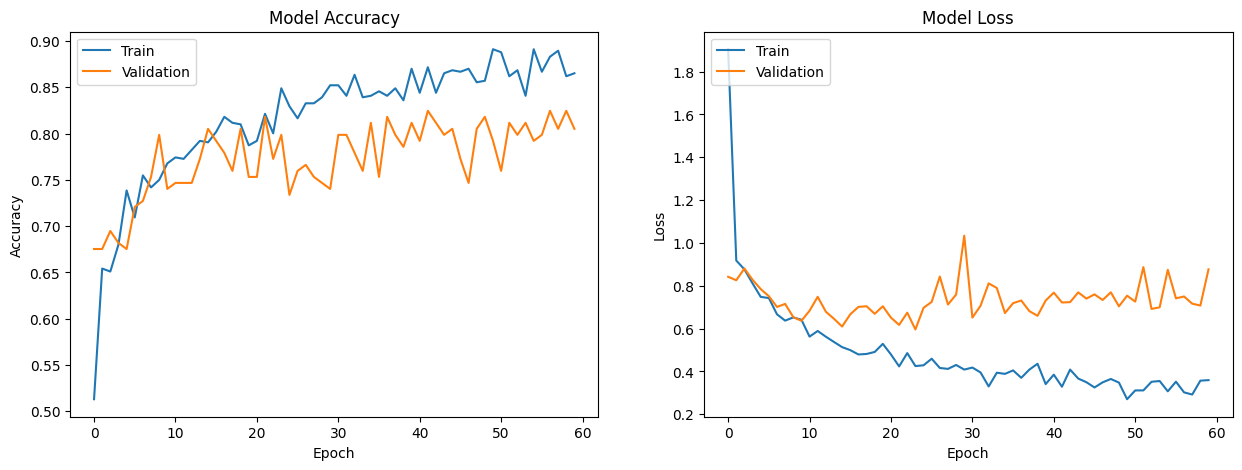

In [51]:
plot_training_results(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step 


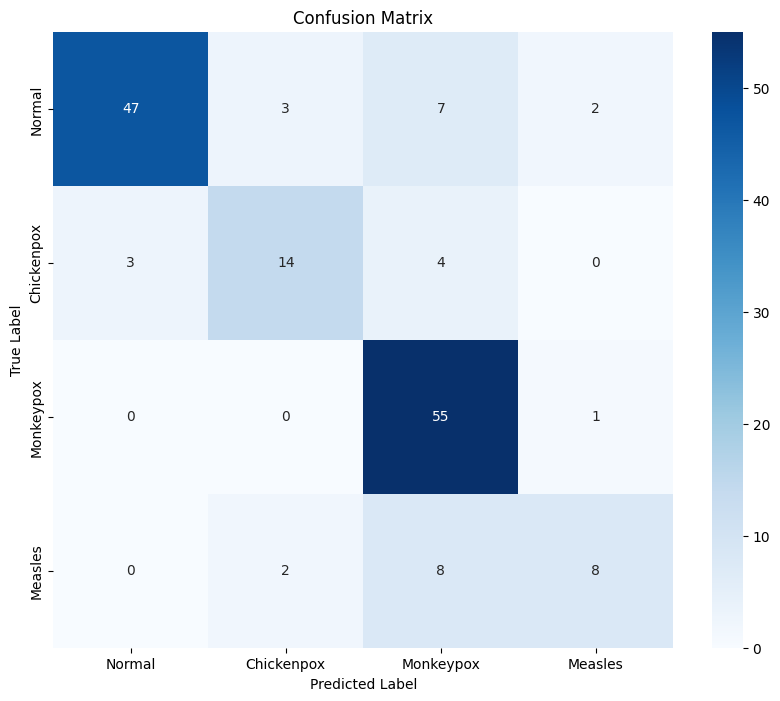


Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.80      0.86        59
  Chickenpox       0.74      0.67      0.70        21
   Monkeypox       0.74      0.98      0.85        56
     Measles       0.73      0.44      0.55        18

    accuracy                           0.81       154
   macro avg       0.79      0.72      0.74       154
weighted avg       0.82      0.81      0.80       154



In [50]:
y_pred = model.predict(X_val)

class_names = ['Normal', 'Chickenpox', 'Monkeypox', 'Measles']
plot_confusion_matrix(y_val, y_pred, class_names)

print("\nClassification Report:")
print(classification_report(np.argmax(y_val, axis=1), 
                          np.argmax(y_pred, axis=1),
                          target_names=class_names))

# ResNet50

In [52]:
ResNet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_HEIGHT, 3))

for layer in ResNet50_base.layers:
    layer.trainable = False

x = Flatten()(ResNet50_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(4, activation='softmax')(x)  

model = Model(inputs=ResNet50_base.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [53]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [54]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 49,279,108 (187.98 MB)

 Trainable params: 25,691,396 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [55]:
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator
)

Epoch 1/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.3749 - loss: 7.2642 - val_accuracy: 0.3636 - val_loss: 1.3765
Epoch 2/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3454 - loss: 1.3753 - val_accuracy: 0.3831 - val_loss: 1.3468
Epoch 3/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3862 - loss: 1.3401 - val_accuracy: 0.3831 - val_loss: 1.3257
Epoch 4/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3700 - loss: 1.3243 - val_accuracy: 0.3831 - val_loss: 1.3093
Epoch 5/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.3694 - loss: 1.3108 - val_accuracy: 0.3831 - val_loss: 1.2961
Epoch 6/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3774 - loss: 1.2819 - val_accuracy: 0.3831 - val_loss: 1.2865
Epoch 7/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3872 - loss: 1.2814 - val_accuracy: 0.3831 - val_loss: 1.2792
Epoch 8/40
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3452 - loss: 1.2960 - val_acc

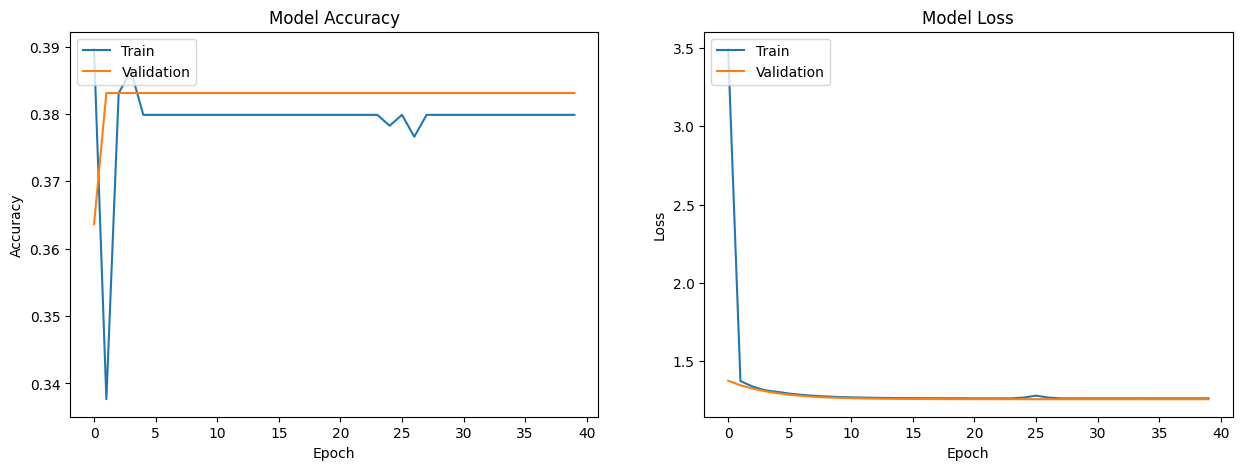

In [56]:
plot_training_results(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


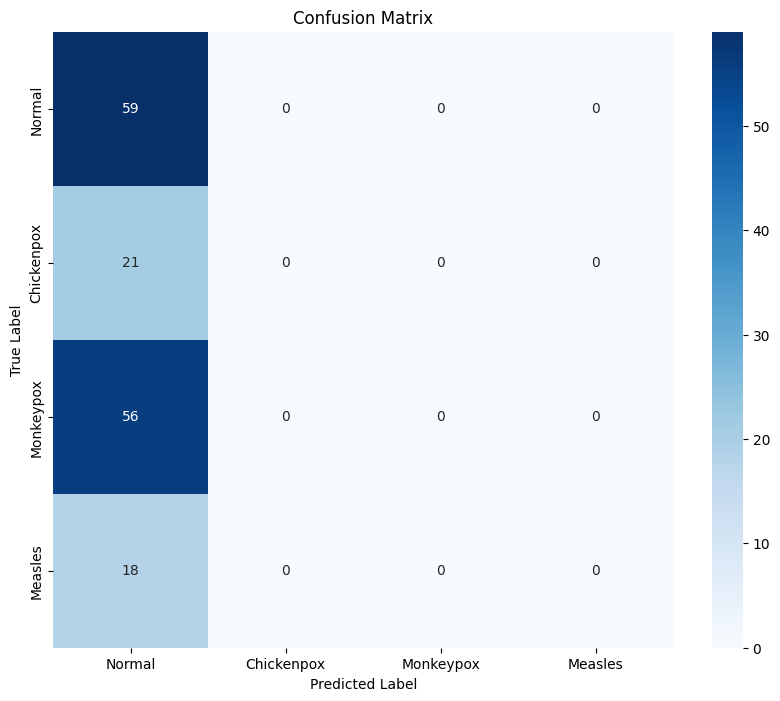


Classification Report:
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55        59
  Chickenpox       0.00      0.00      0.00        21
   Monkeypox       0.00      0.00      0.00        56
     Measles       0.00      0.00      0.00        18

    accuracy                           0.38       154
   macro avg       0.10      0.25      0.14       154
weighted avg       0.15      0.38      0.21       154



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
y_pred = model.predict(X_val)

class_names = ['Normal', 'Chickenpox', 'Monkeypox', 'Measles']
plot_confusion_matrix(y_val, y_pred, class_names)

print("\nClassification Report:")
print(classification_report(np.argmax(y_val, axis=1), 
                          np.argmax(y_pred, axis=1),
                          target_names=class_names))